In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM , GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np



In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")
     

No GPU


In [3]:
df = pd.read_csv(".\data\data.csv", sep=";")

df.head(10)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


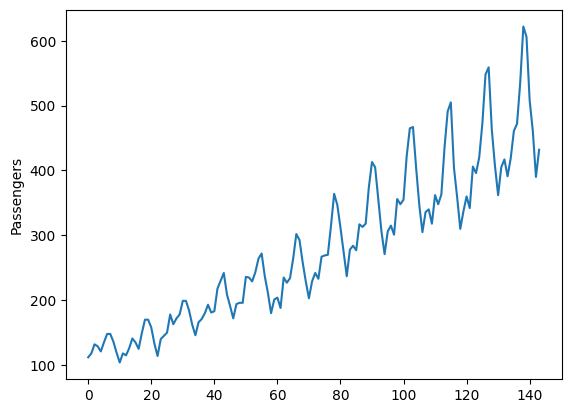

In [4]:
plt.plot( df["Passengers"])

plt.ylabel("Passengers")
plt.show()

In [5]:
dataset = df["Passengers"].to_numpy()
dataset = dataset.astype('float32')
dataset= dataset.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(144, 1)

In [6]:
dataset[:10]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

In [7]:
def slide_window(dataset, look_back=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        data_X.append(a)
        data_Y.append(dataset[i + look_back, 0])
    return np.array(data_X), np.array(data_Y)




In [10]:

step = 3
X,Y = slide_window(dataset, step)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=True)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [11]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((98, 3, 1), (98,), (21, 3, 1), (21,), (21, 3, 1), (21,))

In [41]:
X_train.shape

(98, 3, 1)

In [ ]:
bs = 32
nbn = 256
dp = 0.1

with tf.device(device_name):
  model = Sequential([
      LSTM(int(nbn), return_sequences=True,input_shape=(step, 1)),
      Dropout(dp),
      LSTM(int(nbn)*2, return_sequences=False),
      Dropout(dp),
      Dense(1),
      Activation('linear')
  ])

  checkpointer = ModelCheckpoint(filepath='models/passengers-LSTM.h5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
  early = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='auto')

  model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])
  
  model.summary()

  history = model.fit(X_train, Y_train,
                        batch_size=int(bs), epochs=1000,
                        verbose=1,
                        callbacks = [checkpointer, early],
                        validation_data=(X_val, Y_val))

  print(history.history['val_mean_absolute_percentage_error'][-1])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 3, 256)            264192    
                                                                 
 dropout_26 (Dropout)        (None, 3, 256)            0         
                                                                 
 lstm_27 (LSTM)              (None, 512)               1574912   
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
 activation_13 (Activation)  (None, 1)                 0         
                                                                 
Total params: 1,839,617
Trainable params: 1,839,617
N

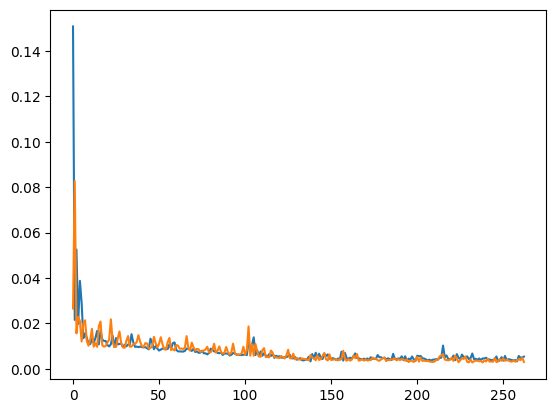

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


In [58]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 31ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_percentage_error: 26.4732


[0.0023227876517921686, 0.0023227876517921686, 26.473176956176758]

In [59]:
result = model.predict(X_test)

1/1 [==============================] - 0s 488ms/step


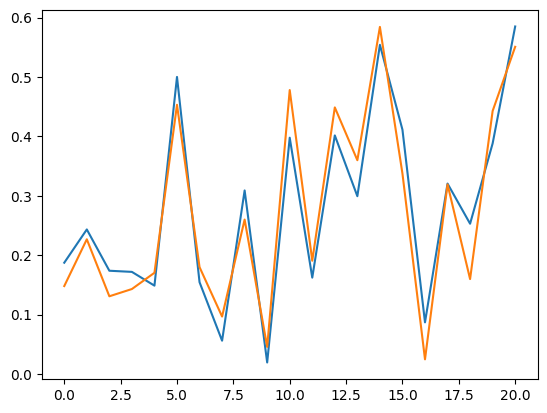

In [61]:

plt.plot(Y_test)
plt.plot(result)


In [67]:
# Define the objective function
def objective(data ):
    bs,nbn,dp = data
    with tf.device(device_name):
        model = Sequential([
            LSTM(int(nbn), return_sequences=True,input_shape=(step, 1)),
            Dropout(dp),
            LSTM(int(nbn)*2, return_sequences=False),
            Dropout(dp),
            Dense(1),
            Activation('linear')
        ])

        checkpointer = ModelCheckpoint(filepath='models/airline-passengers.h5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
        early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

        model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])
        

        history = model.fit(X_train, Y_train,
                                batch_size=int(bs), epochs=1000,
                                verbose=0,
                                callbacks = [checkpointer, early],
                                validation_data=(X_val, Y_val))

        return history.history['val_mean_squared_error'][-1]


spaces = [(32, 256),
          (32,512),
          (0.1,0.4)]  

# Perform Bayesian Optimization
res = gp_minimize(objective,          
                  spaces,              
                  n_calls=10,         # The number of evaluations of f
                  random_state=0,
                  verbose=True)     


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.7759
Function value obtained: 0.0121
Current minimum: 0.0121
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.3887
Function value obtained: 0.0204
Current minimum: 0.0121
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.3625
Function value obtained: 0.0430
Current minimum: 0.0121
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.5227
Function value obtained: 0.0129
Current minimum: 0.0121
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.8544
Function value obtained: 0.0210
Current minimum: 0.0121
Iteration No: 6 started. Evaluating

In [68]:
print(res.x)
bs,nbn,dp = res.x
with tf.device(device_name):
  model = Sequential([
            LSTM(nbn, return_sequences=True,input_shape=(step, 1)),
            Dropout(dp),
            LSTM(nbn*2, return_sequences=False),
            Dropout(dp),
            Dense(1),
            Activation('linear')
  ])

  checkpointer = ModelCheckpoint(filepath='models/airline-passengers-LSTM.h5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
  early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

  model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])
  
  model.summary()

  history = model.fit(X_train, Y_train,
                        batch_size=int(bs), epochs=500,
                        verbose=1,
                        callbacks = [checkpointer, early],
                        validation_data=(X_val, Y_val))

  print(history.history['val_mean_absolute_percentage_error'][-1])

[63, 450, 0.24208241358211322]
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 3, 450)            813600    
                                                                 
 dropout_112 (Dropout)       (None, 3, 450)            0         
                                                                 
 lstm_113 (LSTM)             (None, 900)               4863600   
                                                                 
 dropout_113 (Dropout)       (None, 900)               0         
                                                                 
 dense_56 (Dense)            (None, 1)                 901       
                                                                 
 activation_56 (Activation)  (None, 1)                 0         
                                                                 
Total params: 5,678,10

In [69]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 42ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_percentage_error: 53.4681


[0.010586448013782501, 0.010586448013782501, 53.468082427978516]